In [1]:
from IPython.core.interactiveshell import InteractiveShell
import time

old_run_cell = InteractiveShell.run_cell

def timing_run_cell(self, raw_cell, *args, **kwargs):
    t0 = time.time()
    result = old_run_cell(self, raw_cell, *args, **kwargs)
    t1 = time.time()
    print(f"Execution time: {t1 - t0:.1f} seconds")
    return result

InteractiveShell.run_cell = timing_run_cell

In [2]:
# !pip install zoobot
# !pip install pyro-ppl
# !pip install pytorch_lightning
# !pip install timm

Execution time: 0.0 seconds


In [3]:
import sys
sys.path.append('../Scripts')

import warnings
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split, ConcatDataset, WeightedRandomSampler
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from zoobot.pytorch.training import finetune
import torchvision.transforms.v2 as T
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier, LinearHead
from torchvision.models import efficientnet_b0

from auxiliary_functions import (aggressive_arcsinh_scaling, ClassificationDataset_values, 
                        train_epoch, multilabel_train_epoch, evaluate, multilabel_evaluate, compute_metrics, evaluate_with_probabilities, 
                        multilabel_evaluate_with_probabilities, plot_confusion_matrix, multilabel_plot_confusion_matrix, FocalLossBCE,
                        AugmentedMinorityDataset)
from DataCore import ClassificationDataset_labels, ClassificationArrayDataset


Execution time: 8.0 seconds


In [4]:
unityTransform = lambda x: x

# Load labels and data
label_file = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(label_file)[1]  # second HDU
label_vals = labels.data

datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"

# n_total = len(label_vals)

# is_pre       = (label_vals['is_pre_merger'] == 1)
# is_ongoing   = (label_vals['is_ongoing_merger'] == 1)
# is_post      = (label_vals['is_post_merger'] == 1)
# bit0         = is_pre.astype(int)
# bit1         = (is_ongoing | is_post).astype(int)

# all_multilabels = bit0*2 + bit1

# indices = np.arange(n_total)

# dataset = ClassificationArrayDataset(datadir, labels, aggressive_arcsinh_scaling)

#all_multilabels = np.array([torch.dot(label_tensor.to(torch.int), torch.tensor([2, 1], dtype=torch.int)).item() for _, label_tensor in dataset])

# dataset splits - you gotta stratify to make sure that all the datasets have galaxies with all labels, otherwise you end up with no pre/post mergers in val or test splits
# First split: 90% train+val, 10% test
# trainval_indices, test_indices = train_test_split(
#     np.arange(len(dataset)), test_size=0.1, stratify=all_multilabels, random_state=42
# )
# # Second split: of the 90%, 90% train, 10% val (so total 81/9/10)
# trainval_labels = all_multilabels[trainval_indices]
# train_indices, val_indices = train_test_split(
#     trainval_indices, test_size=0.1, stratify=trainval_labels, random_state=42
# )

# Create the dataset using the scaling
dataset = ClassificationArrayDataset(datadir, labels, aggressive_arcsinh_scaling)

# all_multilabels = []
# for i in range(len(dataset)):
#     _, label = dataset[i]
#     all_multilabels.append(label.item())
# all_multilabels = np.array(all_multilabels)

# all_multilabels = np.array([torch.dot(label_tensor.to(torch.int), torch.tensor([2, 1], dtype=torch.int)).item() for _, label_tensor in dataset])

all_multilabels = []
for i in range(len(dataset)):
    _, label_tensor = dataset[i]  # label_tensor is shape [2]
    arr = label_tensor.numpy().astype(int)  # e.g. [0,1], [1,1], etc.
    # Convert [a,b] -> single int in [0..3]
    single_class = arr[0]*2 + arr[1]  # e.g. [1,0] => 2*1 + 0 = 2
    all_multilabels.append(single_class)

all_multilabels = np.array(all_multilabels)

# First split: 90% train+val, 10% test
trainval_indices, test_indices = train_test_split(
    np.arange(len(dataset)),
    test_size=0.1,
    stratify=all_multilabels,
    random_state=42
)

# Second split: of the 90%, 90% train, 10% val (so total 81/9/10)
trainval_labels = all_multilabels[trainval_indices]
train_indices, val_indices = train_test_split(
    trainval_indices,
    test_size=0.1,
    stratify=trainval_labels,
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

#Identify minorities (any merger => bit0=1 or bit1=1) vs majority (bit0=0 and bit1=0)
# minority_indices = []
# majority_indices = []
# for i in range(len(base_train_dataset)):
#     ds_idx = train_indices[i]  # the original global index
#     row = label_vals[ds_idx]
#     # bit0 => pre, bit1 => (ongoing|post)
#     b0 = 1 if (row['is_pre_merger'] == 1) else 0
#     b1 = 1 if ((row['is_ongoing_merger'] == 1) or (row['is_post_merger'] == 1)) else 0
#     if b0==0 and b1==0:
#         minority_indices.append(i)
#     else:
#         majority_indices.append(i)

# minority_dataset = Subset(base_train_dataset, minority_indices)
# majority_dataset = Subset(base_train_dataset, majority_indices)

# # Over-sample minority + data augmentation
# transformation = T.RandomChoice([
#     T.RandomRotation(degrees=(0,360)),
#     T.RandomHorizontalFlip(),
#     T.RandomVerticalFlip()
# ])

# aug_minority_dataset = AugmentedMinorityDataset(minority_dataset, transformation, times=3)
# combined_train_dataset = ConcatDataset([majority_dataset, aug_minority_dataset])

# # WeightedRandomSampler to under-sample majority
# weights = []
# len_majority = len(majority_dataset)
# for i in range(len(combined_train_dataset)):
#     if i < len_majority:
#         # sample from majority subset
#         weights.append(0.2)  # smaller => under-sample
#     else:
#         # sample from augmented minority
#         weights.append(1.0)  # bigger => more likely
# weights = torch.DoubleTensor(weights)

# sampler = WeightedRandomSampler(
#     weights,
#     num_samples=len(combined_train_dataset),  # same #samples per epoch
#     replacement=True
# )

batch_size = 200
#train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, sampler=sampler, num_workers=32) # no shuffle needed, we have sampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

# train_counts = [0, 0, 0]
# for i in train_indices:
#     row = labels.data[i]
#     if row['is_pre_merger'] == 1: 
#         train_counts[1] += 1
#     elif row['is_ongoing_merger'] == 1 or row['is_post_merger'] == 1: 
#         train_counts[2] += 1
#     else: 
#         train_counts[0] += 1
# weights = 1.0 / np.array(train_counts)
# weights /= weights.sum()
# weights_t = torch.tensor(weights, dtype=torch.float)

pos_count = [0,0]
neg_count = [0,0]

for i in train_indices:
    _, label_tensor = dataset[i]
    arr = label_tensor.numpy().astype(int)  # shape [2]
    for dim in [0,1]:
        if arr[dim] == 1:
            pos_count[dim] += 1
        else:
            neg_count[dim] += 1

pos_weight_vals = []
for dim in [0,1]:
    # If no positives for that dim, skip or set pos_weight=1.0 to avoid zero-div
    if pos_count[dim] == 0:
        pos_weight_vals.append(1.0)
    else:
        pw = neg_count[dim] / float(pos_count[dim])
        pos_weight_vals.append(pw)

# pos_count = [0, 0]
# neg_count = [0, 0]

# for i in train_indices:
#     row = label_vals[i]
#     is_pre = (row['is_pre_merger'] == 1)
#     is_ongoing = (row['is_ongoing_merger'] == 1)
#     is_post = (row['is_post_merger'] == 1)
    
#     # bit0 => pre, bit1 => (ongoing or post)
#     bit0 = 1 if is_pre else 0
#     bit1 = 1 if (is_ongoing or is_post) else 0
    
#     for dim, bit in enumerate([bit0, bit1]):
#         if bit == 1:
#             pos_count[dim] += 1
#         else:
#             neg_count[dim] += 1

# pos_weight_vals = []
# for dim in [0, 1]:
#     if pos_count[dim] == 0:
#         pos_weight_vals.append(1.0)
#     else:
#         pw = neg_count[dim] / float(pos_count[dim])
#         pos_weight_vals.append(pw)

# pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float)

# pos_count = [0.0, 0.0]
# neg_count = [0.0, 0.0]

# len_majority = len(majority_dataset)
# len_aug_minority = len(aug_minority_dataset)
# combined_len = len_majority + len_aug_minority

# for i in range(combined_len):
#     if i < len_majority:
#         weight = 0.2
#         ds_idx = majority_indices[i]
#     else:
#         weight = 1.0
#         base_idx = (i - len_majority) // 3
#         ds_idx = minority_indices[base_idx]

#     row = label_vals[ds_idx]
#     is_pre = (row['is_pre_merger'] == 1)
#     is_ongoing = (row['is_ongoing_merger'] == 1)
#     is_post = (row['is_post_merger'] == 1)

#     b0 = 1 if is_pre else 0
#     b1 = 1 if (is_ongoing or is_post) else 0

#     for dim, bit in enumerate([b0, b1]):
#         if bit == 1:
#             pos_count[dim] += weight
#         else:
#             neg_count[dim] += weight

# pos_weight_vals = []
# for dim in [0, 1]:
#     if pos_count[dim] == 0:
#         pos_weight_vals.append(1.0)
#     else:
#         ratio = neg_count[dim] / pos_count[dim]
#         pos_weight_vals.append(ratio)

# pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float)

# Model Setup with Zoobot (One-Stage Classification)
# load the Zoobot pre-trained EfficientNet-B0 model
model = FinetuneableZoobotClassifier(
    name='hf_hub:mwalmsley/zoobot-encoder-efficientnet_b0',
    n_blocks=0, # number of layers to train - max 7 for efficientnet_b0, set 0 for only head
    learning_rate=1e-5,
    lr_decay=0.5,
    num_classes=2
)
# uncomment below to use torchvision's EfficientNet-B0 (note: this model is pre-trained on ImageNet, not on Galaxy Zoo labels)
#model = efficientnet_b0(pretrained=True)

# Modify the classifier head to output classes
if hasattr(model, 'head'):
    in_features = model.head.linear.in_features
    # dropout
    model.head.dropout.p = 0.2
    
    model.head.linear = nn.Linear(in_features, 2)
else:
    raise ValueError("Model structure not recognized. Adjust or face my wrath.")

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Execution time: 2213.4 seconds


In [5]:
model.head

LinearHead(
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=1280, out_features=2, bias=True)
)

Execution time: 0.0 seconds


In [6]:
with fits.open(label_file) as hdul:
    data = hdul[1].data  # The second HDU

n_total = len(data)

n_pre = len(data[data['is_pre_merger'] == 1])
n_ongoing = len(data[data['is_ongoing_merger'] == 1])
n_post = len(data[data['is_post_merger'] == 1])

n_non = n_total - (n_pre + n_ongoing + n_post)

print(f"Total galaxies: {n_total}")
print(f"Pre-merger: {n_pre} ({n_pre / n_total * 100:.2f}%)")
print(f"Ongoing merger: {n_ongoing} ({n_ongoing / n_total * 100:.2f}%)")
print(f"Post-merger: {n_post} ({n_post / n_total * 100:.2f}%)")
print(f"Non-merger: {n_non} ({n_non / n_total * 100:.2f}%)")

Total galaxies: 58436
Pre-merger: 1267 (2.17%)
Ongoing merger: 511 (0.87%)
Post-merger: 636 (1.09%)
Non-merger: 56022 (95.87%)
Execution time: 0.1 seconds


Total galaxies: 58436

Pre-merger: 1267 (2.17%)

Ongoing merger: 511 (0.87%)

Post-merger: 636 (1.09%)

Non-merger: 56022 (95.87%)

In [7]:
n_00 = 0  # neither pre nor post
n_10 = 0  # pre only
n_01 = 0  # post only
n_11 = 0  # pre + post

for row in data:
    is_pre = (row['is_pre_merger'] == 1)
    is_ongoing = (row['is_ongoing_merger'] == 1)
    is_post = (row['is_post_merger'] == 1)
    
    bit0 = 1 if is_pre else 0
    bit1 = 1 if (is_ongoing or is_post) else 0
    
    if bit0 == 0 and bit1 == 0:
        n_00 += 1
    elif bit0 == 1 and bit1 == 0:
        n_10 += 1
    elif bit0 == 0 and bit1 == 1:
        n_01 += 1
    else:
        n_11 += 1

print(f"Total galaxies: {n_total}")
print(f"00 (no pre, no post): {n_00} ({n_00/n_total*100:.2f}%)")
print(f"10 (pre only):       {n_10} ({n_10/n_total*100:.2f}%)")
print(f"01 (post only):      {n_01} ({n_01/n_total*100:.2f}%)")
print(f"11 (pre + post):     {n_11} ({n_11/n_total*100:.2f}%)")

Total galaxies: 58436
00 (no pre, no post): 56053 (95.92%)
10 (pre only):       1236 (2.12%)
01 (post only):      1116 (1.91%)
11 (pre + post):     31 (0.05%)
Execution time: 2.1 seconds


In [8]:
checking = []
for i in test_indices:
    row = labels.data[i]
    if row['is_pre_merger'] == 1:
        checking.append(1)
    elif row['is_ongoing_merger'] == 1 or row['is_post_merger'] == 1:
        checking.append(2)
    else:
        checking.append(0)

unique, counts = np.unique(checking, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5606, 1: 127, 2: 111}
Execution time: 0.2 seconds


In [9]:
# Hyperparameters (following the paper's one-stage configuration)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.005)
pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float)
criterion = FocalLossBCE(gamma=2.0, alpha=1.0, pos_weight=pos_weight.to(device))#nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.CrossEntropyLoss(weight=weights_t.to(device))

# training and validation Loop

warnings.filterwarnings("ignore")
num_epochs = 10
best_val_loss = np.inf
best_bal_acc = 0
train_losses, train_accuracies = [], []
val_losses, val_accuracies, balanced_accuracies = [], [], []

for epoch in range(num_epochs):
    last_print_time = time.time()
    train_loss, train_acc = multilabel_train_epoch(model, train_loader, criterion, optimizer, device, thresh=0.5)
    val_loss, val_acc, val_preds, val_labels, balanced_acc = multilabel_evaluate(model, val_loader, criterion, device, thresh=0.5)
    current_time = time.time()
    elapsed = current_time - last_print_time
    print(f"\n[{elapsed:.1f}s elapsed] Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss = {train_loss:.3f}, Train Acc = {train_acc:.3f}; "
          f"Val Loss = {val_loss:.3f}, Val Acc = {val_acc:.3f}, Bal Acc = {balanced_acc:.3f}")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    balanced_accuracies.append(balanced_acc)
    
    # Save the best model based on validation loss
    if balanced_acc > best_bal_acc:
        best_bal_acc = balanced_acc
        torch.save(model.state_dict(), "best_model.pth")


[302.4s elapsed] Epoch 1/10: Train Loss = 0.338, Train Acc = 0.169; Val Loss = 0.337, Val Acc = 0.251, Bal Acc = 0.580

[297.4s elapsed] Epoch 2/10: Train Loss = 0.336, Train Acc = 0.287; Val Loss = 0.335, Val Acc = 0.344, Bal Acc = 0.621

[282.4s elapsed] Epoch 3/10: Train Loss = 0.334, Train Acc = 0.377; Val Loss = 0.332, Val Acc = 0.401, Bal Acc = 0.638

[285.9s elapsed] Epoch 4/10: Train Loss = 0.332, Train Acc = 0.407; Val Loss = 0.330, Val Acc = 0.426, Bal Acc = 0.644

[281.4s elapsed] Epoch 5/10: Train Loss = 0.330, Train Acc = 0.442; Val Loss = 0.328, Val Acc = 0.462, Bal Acc = 0.645

[284.4s elapsed] Epoch 6/10: Train Loss = 0.329, Train Acc = 0.468; Val Loss = 0.326, Val Acc = 0.480, Bal Acc = 0.652

[287.0s elapsed] Epoch 7/10: Train Loss = 0.327, Train Acc = 0.484; Val Loss = 0.324, Val Acc = 0.492, Bal Acc = 0.649

[295.0s elapsed] Epoch 8/10: Train Loss = 0.326, Train Acc = 0.500; Val Loss = 0.322, Val Acc = 0.501, Bal Acc = 0.644

[286.5s elapsed] Epoch 9/10: Train Loss


Test Loss: 0.323
Test Accuracy: 0.519
Test Balanced Accuracy: 0.603


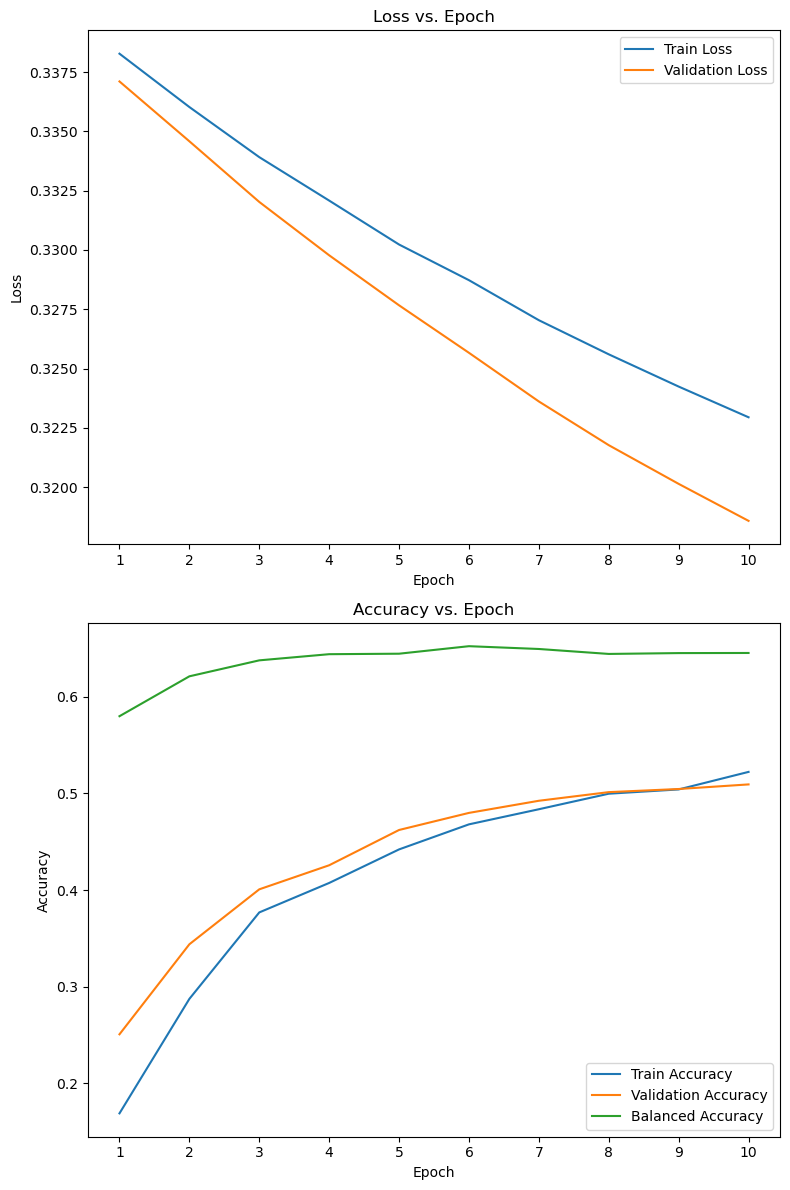

<Figure size 600x500 with 0 Axes>

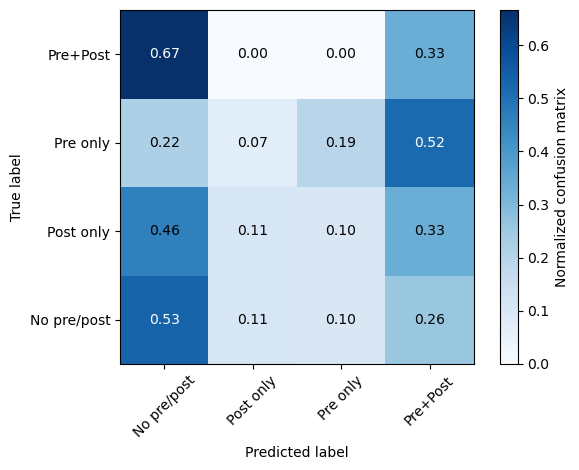

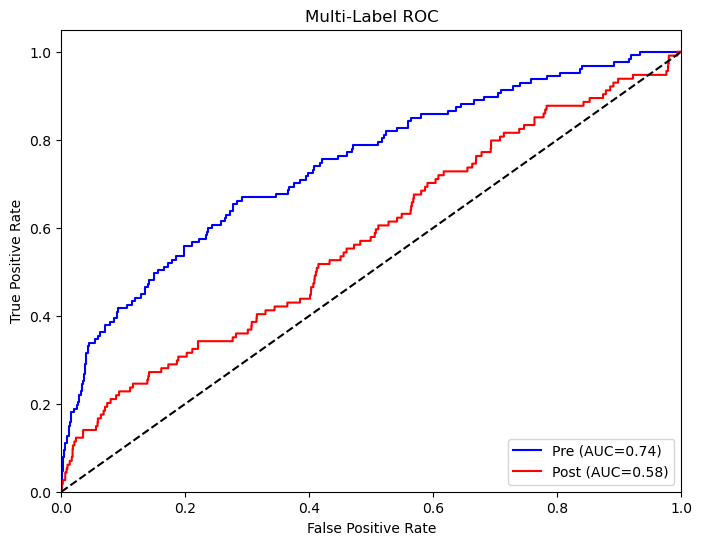

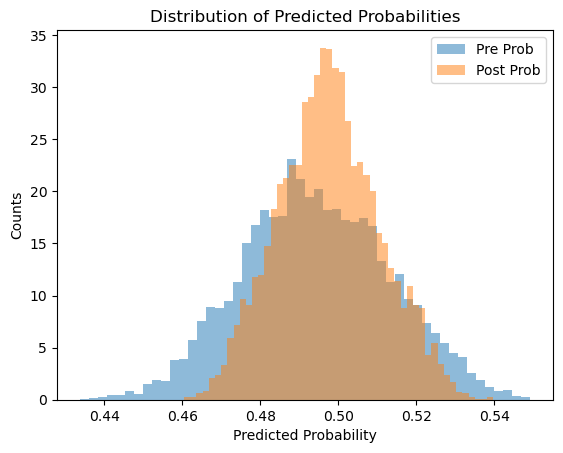

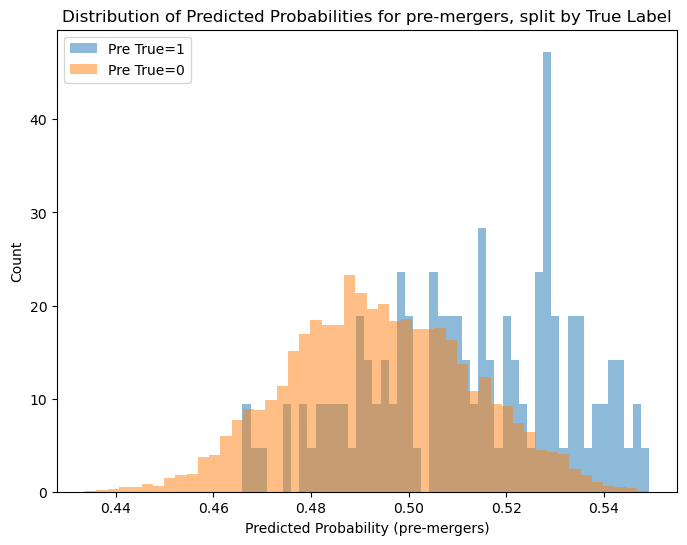

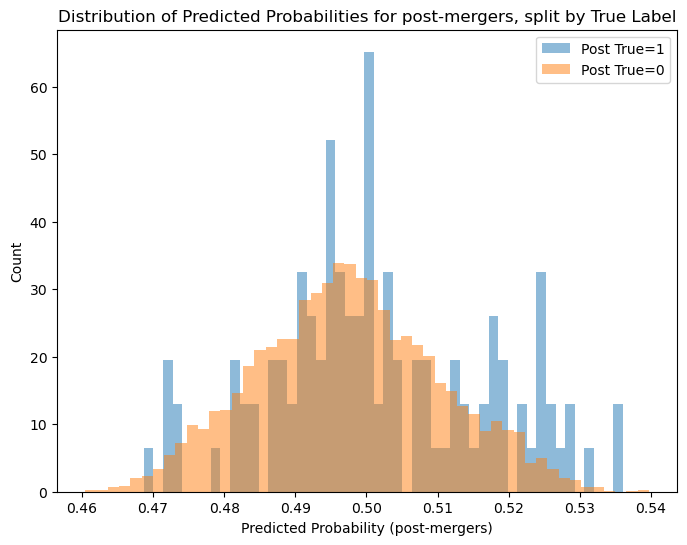

{0.0: 7383, 1.0: 4305}
Execution time: 90.1 seconds


In [10]:
# Evaluation on Test Set
test_loss, test_acc, test_preds, test_labels, balanced_acc = multilabel_evaluate(model, test_loader, criterion, device, thresh=0.5)
print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test Balanced Accuracy: {balanced_acc:.3f}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

ax1.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
ax1.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
ax1.set_xticks(range(1, num_epochs+1))
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs. Epoch")
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
ax2.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
ax2.plot(range(1, num_epochs+1), balanced_accuracies, label="Balanced Accuracy")
ax2.set_xticks(range(1, num_epochs+1))
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs. Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

#confusion matrix
test_labels_arr, test_preds_arr = np.array(test_labels), np.array(test_preds)

plt.figure(figsize=(6,5))
multilabel_plot_confusion_matrix(
    y_true=test_labels_arr,
    y_pred=test_preds_arr,
    classes=["No pre/post","Post only","Pre only","Pre+Post"],#['Non-merger', 'Pre-merger', 'Post-merger'],#
    normalize=True
)

# Compute probabilities on the test set
model.load_state_dict(torch.load("best_model.pth"))
test_probs, test_labels = multilabel_evaluate_with_probabilities(model, test_loader, device)
test_preds = np.argmax(test_probs, axis=1)

fpr, tpr, roc_auc = {}, {}, {}

for i, name in enumerate(["Pre-merger", "Post-merger"]):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = ["blue", "red"]
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"{['Pre','Post'][i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Label ROC")
plt.legend(loc="lower right")
plt.show()

plt.hist(test_probs[:,0], density=True, bins=50, alpha=0.5, label="Pre Prob")
plt.hist(test_probs[:,1], density=True, bins=50, alpha=0.5, label="Post Prob")
plt.xlabel("Predicted Probability")
plt.ylabel("Counts")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.show()

bit0_pos_idx = (test_labels[:, 0] == 1)  # true positives
bit0_neg_idx = (test_labels[:, 0] == 0)  # true negatives

pos_probs = test_probs[bit0_pos_idx, 0]
neg_probs = test_probs[bit0_neg_idx, 0]

plt.figure(figsize=(8,6))
plt.hist(pos_probs, density=True, bins=50, alpha=0.5, label="Pre True=1")
plt.hist(neg_probs, density=True, bins=50, alpha=0.5, label="Pre True=0")
plt.xlabel("Predicted Probability (pre-mergers)")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities for pre-mergers, split by True Label")
plt.legend()
plt.show()

bit0_pos_idx = (test_labels[:, 1] == 1)  # true positives
bit0_neg_idx = (test_labels[:, 1] == 0)  # true negatives

pos_probs = test_probs[bit0_pos_idx, 1]
neg_probs = test_probs[bit0_neg_idx, 1]

plt.figure(figsize=(8,6))
plt.hist(pos_probs, density=True, bins=50, alpha=0.5, label="Post True=1")
plt.hist(neg_probs, density=True, bins=50, alpha=0.5, label="Post True=0")
plt.xlabel("Predicted Probability (post-mergers)")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities for post-mergers, split by True Label")
plt.legend()
plt.show()

unique, counts = np.unique(test_preds_arr, return_counts=True)
print(dict(zip(unique, counts)))